In [2]:
import numpy 
from matplotlib import pyplot
from amuse.units import units, constants
from amuse.lab import nbody_system
from amuse.couple import bridge
from amuse.community.huayno import Huayno
from amuse.ic.salpeter import new_salpeter_mass_distribution
from amuse.ic.plummer import new_plummer_model
from amuse.ic.fractalcluster import new_fractal_cluster_model
from amuse.lab import Particle, Particles, units, nbody_system
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import math, numpy
from matplotlib import pyplot
from amuse.lab import *
from optparse import OptionParser
from amuse.ext.LagrangianRadii import LagrangianRadii
from amuse.community.ph4.interface import ph4

In [3]:
# Define the Milky Way potential with a bulge, disk, and halo - borrowed from Bovy 2015

class MilkyWay_galaxy(object):
    def __init__(
        self, 
        Mb=1.40592e10 | units.MSun,
        Md=8.5608e10 | units.MSun,
        Mh=1.07068e11 | units.MSun,
    ):
        self.Mb = Mb
        self.Md = Md
        self.Mh = Mh

    def get_potential_at_point(self,eps,x,y,z):
        r = (x**2+y**2+z**2)**0.5
        R = (x**2+y**2)**0.5
        # bulge
        b1 = 0.3873 | units.kpc
        pot_bulge = -constants.G*self.Mb/(r**2+b1**2)**0.5 
        # disk
        a2 = 5.31 | units.kpc
        b2 = 0.25 | units.kpc
        pot_disk = -constants.G*self.Md/(R**2 + (a2+ (z**2+ b2**2)**0.5 )**2 )**0.5
        # halo
        a3 = 12.0 | units.kpc
        cut_off = 100 | units.kpc
        d1= r/a3
        c = 1+ (cut_off/a3)**1.02
        pot_halo = (
            -constants.G * (self.Mh/a3) * d1**1.02/(1+ d1**1.02)
            -(constants.G*self.Mh/(1.02*a3))
            * (
                -1.02 / c + numpy.log(c) + 1.02/(1+d1**1.02) 
                - numpy.log(1.0 + d1**1.02)
            )
        )
        return 2*(pot_bulge+pot_disk+ pot_halo)  # multiply by 2 because it is a rigid potential
    
    def get_gravity_at_point(self, eps, x,y,z): 
        r = (x**2+y**2+z**2)**0.5
        R = (x**2+y**2)**0.5
        # bulge
        b1 = 0.3873 | units.kpc
        force_bulge = -constants.G*self.Mb/(r**2+b1**2)**1.5 
        # disk
        a2 = 5.31 | units.kpc
        b2 = 0.25 | units.kpc
        d = a2+ (z**2+ b2**2)**0.5
        force_disk = -constants.G*self.Md/(R**2+ d**2 )**1.5
        # halo
        a3 = 12.0 | units.kpc
        d1 = r/a3
        force_halo = -constants.G*self.Mh*d1**0.02/(a3**2*(1+d1**1.02))
       
        ax = force_bulge*x + force_disk*x  + force_halo*x/r
        ay = force_bulge*y + force_disk*y  + force_halo*y/r
        az = force_bulge*z + force_disk*d*z/(z**2 + b2**2)**0.5 + force_halo*z/r 

        return ax,ay,az

Getting the staring cluster, it is seeded to get the same one to easier comunication between this and hyro code

In [4]:
numpy.random.seed(109)
#setting the initial conditions - number of stars, velocity of the cluster, size of a cluster, position of a cluster
number_of_stars = 100
vel_cluster = 40

masses = new_salpeter_mass_distribution(number_of_stars, 1|units.MSun, 30|units.MSun)
#set to a 1000 particles cluster 
converter = nbody_system.nbody_to_si(masses.sum(), 1|units.parsec)

cluster = new_fractal_cluster_model(number_of_stars, converter)
cluster.mass = masses
cluster.move_to_center()
cluster.position += [8.5, 0, 0] | units.kpc
#cluster.velocity += [0, vel_cluster, 0] |units.kms
# Assign a simple integer ID 0, 1, 2... to easily identify them later
cluster.id = range(len(cluster))

# Verify the massive ones
print(f"Most massive star ID: {cluster[cluster.mass.argmax()].id} (Mass: {cluster.mass.max().in_(units.MSun)})")


# print(cluster.x.value_in(units.parsec).min())
# print(cluster.x.value_in(units.parsec).max())


#Setting the cluster radious to 500 Au to consider the encounters at the moment that stars are 1000 AU away from each other 
cluster.radius = 500 | units.AU
# print(cluster.radius.in_(units.AU))
# print(cluster.virial_radius().in_(units.AU))

cluster_star_mass = []
for i in range(len(cluster)):
    cluster_star_mass.append(cluster[i].mass.value_in(units.MSun))


Most massive star ID: 12 (Mass: 23.5506361406 MSun)


In [85]:

#Saving and reading the cluster to a file

#write_set_to_file(cluster, "cluster_220velocity.csv", "csv")
cluster = read_set_from_file("cluster1.csv", "csv", copy_history = False, close_file = False)
print(f"Most massive star ID: {cluster[cluster.mass.argmax()].id} (Mass: {cluster.mass.max().in_(units.MSun)})")
cluster.velocity += [0, 200, 0] |units.kms

print(cluster)
print(len(cluster))



Most massive star ID: 12.0 (Mass: 23.5506361406 MSun)
                 key           id         mass       radius           vx           vy           vz            x            y            z
                   -         none           kg            m    m * s**-1    m * s**-1    m * s**-1            m            m            m
====================  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========
 9105172100849541679    0.000e+00    3.960e+30    7.480e+13   -9.830e+02    2.400e+05   -1.555e+02    2.622e+20    7.026e+15    8.183e+15
 2075353152735576895    1.000e+00    3.258e+30    7.480e+13    7.368e+02    2.403e+05    1.512e+02    2.623e+20    2.652e+16   -2.248e+15
 1376538427826162611    2.000e+00    4.761e+30    7.480e+13    7.288e+02    2.403e+05    1.599e+02    2.623e+20    2.581e+16   -4.474e+15
   76761269746913145    3.000e+00    2.330e+30    7.480e+13    3.449e-01    2.406e+05    7.577e+01    2.623e+20    1.6

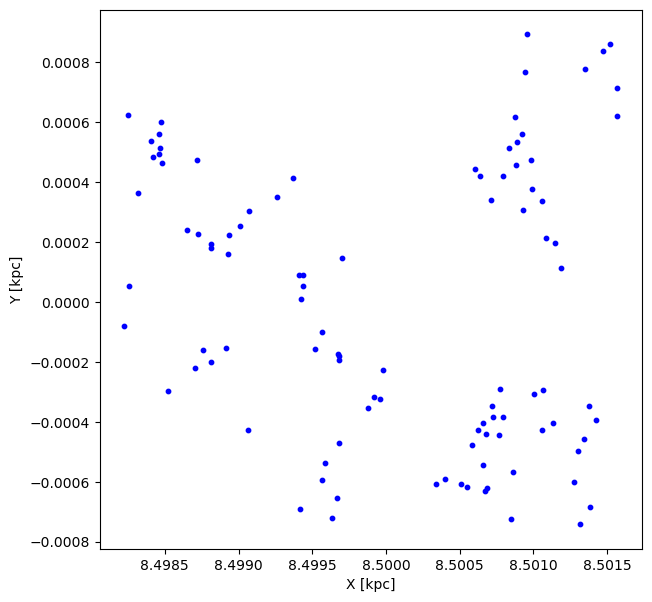

In [86]:
#Plotting the initial state of the cluster
x_start = cluster.x.value_in(units.parsec)
y_start = cluster.y.value_in(units.parsec)
z_start = cluster.z.value_in(units.parsec)

plt.figure(figsize=(7, 7))
plt.scatter(cluster.x.value_in(units.kpc), cluster.y.value_in(units.kpc), c='blue', s=10)
plt.xlabel("X [kpc]")
plt.ylabel("Y [kpc]")
plt.show()

import pandas as pd

# --- SAVE INITIAL STATE to later take a look which type of stars have close encounters ---#
initial_state_list = []

for particle in cluster:
    star_min = []
    for particle2 in cluster:
        dis = ((particle.x.value_in(units.parsec) - particle2.x.value_in(units.parsec))**2 + (particle.y.value_in(units.parsec) - particle2.y.value_in(units.parsec))**2 + (particle.z.value_in(units.parsec) - particle2.z.value_in(units.parsec))**2)**0.5
        if dis > 0:
            star_min.append(dis)
    min(star_min) | units.parsec
    initial_state_list.append({
        "key": particle.key,  # The persistent ID
        "x0": particle.x.value_in(units.parsec),
        "y0": particle.y.value_in(units.parsec),
        "z0": particle.z.value_in(units.parsec),
        "vx0": particle.vx.value_in(units.kms),
        "vy0": particle.vy.value_in(units.kms),
        "vz0": particle.vz.value_in(units.kms),
        "mass": particle.mass.value_in(units.MSun),
        "minimal_distance_to_other_star": min(star_min)
    })

# Convert to DataFrame for easy handling later
df_initial = pd.DataFrame(initial_state_list)



In [87]:
# Save original velocities so we don't break the simulation
original_velocities = cluster.velocity.copy()

# 1. Calculate Center of Mass Velocity
v_cm = cluster.center_of_mass_velocity()
print(f"Center of Mass Velocity: {v_cm.in_(units.kms)}")

# 2. Shift to Center of Mass Frame (Remove bulk motion)
cluster.velocity -= v_cm

# 3. Calculate Energy of the cluster internals
K_internal = cluster.kinetic_energy()
U_internal = cluster.potential_energy()
Q_internal = K_internal / abs(U_internal)
E_internal = K_internal + U_internal

print("-" * 30)
print(f"Internal Kinetic Energy (K): {K_internal.in_(units.J)}")
print(f"Internal Potential Energy (U): {U_internal.in_(units.J)}")
print(f"Internal Virial Ratio (Q):   {Q_internal}")
print(f"Internal Total Energy (E):   {E_internal.in_(units.J)}")

# 4. RESTORE velocities (Critical! Otherwise your simulation stops moving!)
cluster.velocity = original_velocities


Center of Mass Velocity: [2.42197998397e-15, 240.0, 4.35621812904e-14] kms
------------------------------
Internal Kinetic Energy (K): 2.22901278265e+38 J
Internal Potential Energy (U): -4.22604736148e+38 J
Internal Virial Ratio (Q):   0.5274462380531362
Internal Total Energy (E):   -1.99703457883e+38 J


In [88]:
def get_energy_po_k(live_cluster):
    snap = live_cluster.copy()          # Snapshot
    v_cm = snap.center_of_mass_velocity()
    snap.velocity -= v_cm               # Remove bulk motion from snapshot only

    E_kin = 0.5 * snap.mass * snap.velocity.lengths_squared()
    potential_per_mass = snap.potential()
    E_pot = snap.mass * potential_per_mass
    return E_kin, E_pot           


In [89]:
E_kin, E_pot = get_energy_po_k(cluster)
print(f"Total Kinetic Energy: {E_kin}")
print(f"Total Potential Energy: {E_pot[1]}")

Total Kinetic Energy: [1.96388742491e+36, 1.09207362035e+36, 1.59346455442e+36, 4.18239131888e+35, 1.98018686205e+36, 4.77528492415e+36, 3.70194937415e+35, 2.05763092832e+37, 5.89349216373e+34, 8.84898240886e+35, 6.08799262125e+35, 7.31839161285e+35, 6.08706784127e+36, 4.88552609138e+36, 2.66031297522e+36, 1.17414687818e+36, 1.64510191305e+36, 9.24617863539e+35, 7.85336830348e+35, 8.73203212083e+35, 5.22716341343e+35, 8.33835449454e+35, 1.1998647867e+36, 1.7138327275e+36, 1.86692638405e+36, 5.83087829634e+35, 2.66976616377e+36, 2.53363854708e+35, 1.71720694992e+37, 5.22479836771e+36, 5.75745623877e+36, 5.60703069483e+36, 3.29089662455e+35, 2.79396296856e+36, 7.24513045854e+35, 1.39358125979e+36, 1.94346610694e+36, 8.95490331621e+35, 5.39142589795e+35, 2.36648438503e+36, 1.71334628838e+36, 2.48380082206e+36, 2.58584737803e+35, 5.78941272206e+35, 1.28371705435e+36, 9.01121985289e+34, 2.2600146216e+37, 7.36066711745e+34, 1.63036102571e+35, 9.15728880744e+36, 7.54976765598e+35, 3.582520363

In [90]:
def get_internal_energy(live_cluster):
    snap = live_cluster.copy()          # Snapshot
    v_cm = snap.center_of_mass_velocity()
    snap.velocity -= v_cm               # Remove bulk motion from snapshot only
    
    K = snap.kinetic_energy()
    U = snap.potential_energy()
    return K + U, K / abs(U)            # Return E_tot, Q


In [91]:


t_end = 100 | units.Myr
dt = 0.1 | units.Myr
MWG = MilkyWay_galaxy()
t = 0 | units.Myr
limit = 0.01 |units.AU

t_history = []
x_history = []
y_history = []
z_history = []
center_of_mass_history = []
bound_history = []
bound_mass_history = []


energy_overtime = []
Q_overtime = []
t_energy = []
print(f"Center of Mass Velocity: {v_cm.in_(units.kms)}")


gravity_code = ph4(converter, number_of_workers=1)
gravity_code.particles.add_particles(cluster)

channel_from_gd_to_framework = gravity_code.particles.new_channel_to(cluster)

#print("start",gravity_code.model_time.in_(units.Myr))
stopping_condition = gravity_code.stopping_conditions.collision_detection
stopping_condition.enable()

gravity = bridge.Bridge(use_threading=False)
gravity.add_system(gravity_code, (MWG,) )
gravity.evolve_model(t+dt)

#print("start2",gravity_code.model_time.in_(units.Myr))
interactions_list =[]
i = 0                     

print(f"Cluster Velocity Init: {cluster.velocity[0].in_(units.kms)}")
while t < t_end:
    if stopping_condition.is_set():
        # print(gravity.model_time.in_(units.yr))
        t = gravity_code.model_time.in_(units.yr)
        print(gravity_code.model_time.in_(units.yr))
        t_history.append(gravity_code.model_time.in_(units.yr))
        x_history.append(cluster.x.value_in(units.parsec))
        y_history.append(cluster.y.value_in(units.parsec))
        z_history.append(cluster.z.value_in(units.parsec))

        center_of_mass = cluster.center_of_mass()
        center_of_mass_history.append(center_of_mass)

    
        
        
        # Calculate Energy correctly (subtracting bulk motion just for math)
        E_cur, Q_cur = get_internal_energy(cluster)
        
        t_energy.append(gravity_code.model_time.in_(units.yr))
        energy_overtime.append(E_cur.value_in(units.erg))
        Q_overtime.append(Q_cur)


        #Energy of specific particles 
        
        E_kin, E_pot = get_energy_po_k(cluster)

        lim_energy = 0 | units.J
        for i in range(len(cluster)):
            number = 0
            mass = 0 | units.MSun
            if E_kin[i] + E_pot[i] < lim_energy:
                number += 1
                mass += cluster[i].mass
        bound_history.append(number)
        bound_mass_history.append(mass)
        # # print("Collision detected")
        # print(stopping_condition.particles(0), stopping_condition.particles(1))
        #print("time:", t.in_(units.yr))
        part_set_1 = stopping_condition.particles(0)
            
        part_set_2 = stopping_condition.particles(1)
        
        for p1, p2 in zip(part_set_1, part_set_2):
            p1.radius = p1.radius/2
            p2.radius = p2.radius/2
            if p1.radius < limit:
                p1.radius = 0 | units.AU
            if p2.radius < limit:
                p2.radius = 0 | units.AU
            if p1.mass < p2.mass:
                mass_ratio = p2.mass / p1.mass
            else:
                mass_ratio = p1.mass / p2.mass

        # gravity = bridge.Bridge(use_threading=False)
        # gravity.add_system(gravity_code, (MWG,) )
        interactions_list.append((gravity_code.model_time.in_(units.yr), stopping_condition.particles(0).key, stopping_condition.particles(1).key, p1.radius.in_(units.AU), p2.radius.in_(units.AU),p1.x.in_(units.kpc),p1.y.in_(units.kpc),p1.z.in_(units.kpc),p2.x.in_(units.kpc),p2.y.in_(units.kpc),p2.z.in_(units.kpc),p1.vx.in_(units.kms),p1.vy.in_(units.kms),p1.vz.in_(units.kms),p2.vx.in_(units.kms),p2.vy.in_(units.kms),p2.vz.in_(units.kms),p1.mass.in_(units.MSun),p2.mass.in_(units.MSun),mass_ratio))
        gravity.evolve_model(t+dt)
        i += 1
    else:
        t += dt
        t_history.append(gravity_code.model_time.in_(units.yr))
        x_history.append(cluster.x.value_in(units.parsec))
        y_history.append(cluster.y.value_in(units.parsec))
        z_history.append(cluster.z.value_in(units.parsec))
        
    
        gravity.evolve_model(t)
        channel_from_gd_to_framework.copy()
        # print("time next step:", t.in_(units.kyr))
        # print("gravity code time:", gravity_code.model_time.in_(units.kyr))
        E_kin, E_pot = get_energy_po_k(cluster)

        lim_energy = 0 | units.J
        for i in range(len(cluster)):
            number = 0
            mass = 0 | units.MSun
            if E_kin[i] + E_pot[i] < lim_energy:
                number += 1
                mass += cluster[i].mass
        bound_history.append(number)
        bound_mass_history.append(mass)
        
        # Calculate Energy correctly (subtracting bulk motion just for math)
        E_cur, Q_cur = get_internal_energy(cluster)

        t_energy.append(gravity_code.model_time.in_(units.yr))
        energy_overtime.append(E_cur.value_in(units.erg))
        Q_overtime.append(Q_cur)
        cluster.radius = 500 | units.AU

print("end",gravity_code.model_time.in_(units.Myr))
gravity.stop()
print(interactions_list)

Center of Mass Velocity: [2.42197998397e-15, 240.0, 4.35621812904e-14] kms
Cluster Velocity Init: [-0.982990720401, 239.961084822, -0.155514314586] kms
57933.0621155 yr
58532.2817281 yr
58736.2713834 yr
58804.7991583 yr
58831.0946998 yr
58840.2582976 yr
58843.5452403 yr
58844.8400965 yr
58845.4377224 yr
62216.8448776 yr
62554.7027443 yr
62672.6342637 yr
62712.4759933 yr
62727.2174332 yr
62732.3968581 yr
62734.3889446 yr
62735.2853835 yr
83737.7535156 yr
84783.2004992 yr
89143.479382 yr
89602.4561065 yr
89761.8230247 yr
89822.3824537 yr
89842.3033185 yr
89849.6740384 yr
89852.2637508 yr
89853.234893 yr
89853.6333103 yr
89853.8511948 yr
100337.411719 yr
100579.649434 yr
100672.082247 yr
100705.5493 yr
100719.892322 yr
102096.822496 yr
102785.287583 yr
103021.150622 yr
103113.583434 yr
103151.831495 yr
115050.16561 yr
145750.608738 yr
145776.107445 yr
146062.967898 yr
146180.899417 yr
146227.115823 yr
151334.825553 yr
151730.05551 yr
151889.422428 yr
152686.257019 yr
153655.207882 yr
1537

In [92]:
print(len(interactions_list))

168


In [77]:
print(bound_history)
print(bound_mass_history)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [93]:
import csv

# 1. Prepare a clean list of lists
clean_rows = []


In [94]:

for row_tuple in interactions_list:
    cleaned_row = []
    for item in row_tuple:
        # Check if the item is an AMUSE Quantity (has a unit attached)
        if hasattr(item, "number"):
            # .number strips the unit (since you already did .in_() in the main loop)
            cleaned_row.append(item.number)
        
        # Check if the item is a numpy array (like the keys/IDs usually are)
        elif hasattr(item, "__len__") and not isinstance(item, str):
            # Take the first item if it's a list/array (e.g. key [102] -> 102)
            cleaned_row.append(item[0])
            
        # Fallback for standard python types
        else:
            cleaned_row.append(item)
            
    clean_rows.append(cleaned_row)

# 2. Write to CSV
with open("Cluster_velocity_240_good.csv", "w", newline="") as f:
    writer = csv.writer(f)
    # Write header
    writer.writerow(["time (yr)", "particle1_id", "particle2_id", "particle1_radius (AU)", "particle2_radius (AU)", "particle1_x (kpc)","particle1_y (kpc)","particle1_z (kpc)","particle2_x (kpc)","particle2_y (kpc)","particle2_z (kpc)","particle1_vx (km/s)","particle1_vy (km/s)","particle1_vz (km/s)","particle2_vx (km/s)","particle2_vy (km/s)","particle2_vz (km/s)","particle1_mass (MSun)","particle2_mass (MSun)","mass_ratio", "total_energy (erg)", "virial_ratio (Q)"])
    # Write data
    writer.writerows(clean_rows)

print("Interactions saved successfully to interactions.csv")

Interactions saved successfully to interactions.csv


In [ ]:
# print(x_history[0])
# center_of_mass = cluster.center_of_mass()
# print(f"Center of Mass at collision time: {center_of_mass.in_(units.kpc)}")

[ 8498.72791684  8501.51932893  8501.47227495  8500.89044595  8501.56998902
  8499.56923753  8501.30267097  8499.52194195  8501.06502184  8501.35012862
  8499.68269702  8501.57084179  8501.42809924  8499.58482386  8498.22508012
  8500.50642715  8499.70038886  8501.06169356  8500.9928947   8498.81127266
  8500.76724666  8498.5230444   8500.68672224  8499.4402259   8499.67862167
  8501.38475871  8499.63409483  8501.27392905  8499.00795326  8499.68011956
  8499.43784568  8498.71692292  8500.71901213  8498.65263538  8498.31771902
  8501.14449074  8499.26396102  8500.67146199  8500.33998432  8499.67511048
  8499.87799649  8498.91415707  8500.5512889   8498.25000939  8501.13271109
  8501.06087785  8498.92525158  8501.00508631  8500.85940554  8498.8112642
  8498.42234706  8500.66143246  8501.18887408  8499.9176297   8500.67943836
  8499.06386435  8501.34553624  8501.08558529  8499.9818855   8500.58260873
  8499.96304147  8500.62483742  8498.40906039  8500.85044109  8499.42227237
  8498.483062

Plot of a trajectory

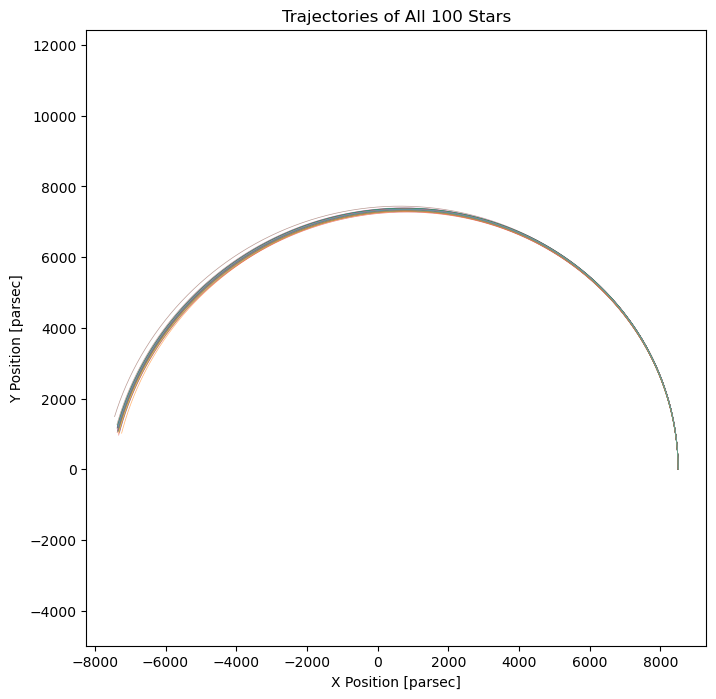

In [28]:
import matplotlib.pyplot as plt
times = numpy.array(t_history)          # Shape: (steps,)
x_all = numpy.array(x_history).T        # Shape: (stars, steps)
y_all = numpy.array(y_history).T        # Shape: (stars, steps)
z_all = numpy.array(z_history).T        # Shape: (stars, steps

# 1. Setup the figure
plt.figure(figsize=(8, 8))

# 2. Iterate through every star and plot its line
# x_all.shape[0] is the number of stars
for i in range(x_all.shape[0]):
    # x_all[i] is the full history of X positions for star 'i'
    # y_all[i] is the full history of Y positions for star 'i'
    
    # We use a thin line (linewidth=0.5) and slight transparency (alpha=0.6) 
    # so it doesn't look too messy if there are many stars.
    plt.plot(x_all[i], y_all[i], linewidth=0.5, alpha=0.6)

# 3. Add labels and title
plt.xlabel('X Position [parsec]')
plt.ylabel('Y Position [parsec]')
plt.title(f'Trajectories of All {x_all.shape[0]} Stars')

# Optional: Ensure the aspect ratio is equal so circles look like circles
plt.axis('equal')

# 4. Show the plot
plt.show()


Here is an animation of trajectoy but it is not working well...

In [81]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# --- SETTINGS ---
# Skip frames to make generation faster (e.g., 5 means plot every 5th time step)
#skip_step = 5 
# Total available steps in your data
total_data_steps = x_all.shape[1] 

fig, ax = plt.subplots(figsize=(7, 7))

lines = []

# 1. Initialize the lines
for i in range(number_of_stars):
    # Initialize with empty data
    # Note: ax.plot returns a list, so we unwrap it with comma: line, = ...
    line, = ax.plot([], [], lw=1, alpha=0.7, label=f"Star {i}")
    lines.append(line)

# 2. Set Axis Limits Automatically based on the data range
# Adding a 10% margin so stars don't hit the edge
x_min, x_max = x_all.min(), x_all.max()
y_min, y_max = y_all.min(), y_all.max()
margin_x = (x_max - x_min) * 0.1
margin_y = (y_max - y_min) * 0.1

ax.set_xlim(x_min - margin_x, x_max + margin_x)
ax.set_ylim(y_min - margin_y, y_max + margin_y)
# ax.set_xlim(8450,8550)
# ax.set_ylim(-20,20)

ax.set_xlabel("x [pc]")
ax.set_ylabel("y [pc]")
ax.set_title(f"Cluster Evolution ({t_end})")

# 3. Update Function
def update(frame):
    # frame is the index of the time step
    for i in range(number_of_stars):
        # Slice from start (0) to current frame to show the full trail
        # x_all[star_index, 0:current_time_index]
        x = x_all[i, :frame]
        y = y_all[i, :frame]
        
        lines[i].set_data(x, y)
    return lines 

# 4. Generate Animation
frames=range(0, total_data_steps) #makes it lighter/faster to generate
ani = animation.FuncAnimation(
    fig=fig, 
    func=update, 
    frames=frames, 
    interval=30, 
    blit=True
)

plt.close() # Prevents showing the static plot underneath
HTML(ani.to_jshtml())
ani.save("cluster_evolution_stopping_conditions_100Myr.mp4", writer="ffmpeg", fps=30)


Animation size has reached 20988822 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


Data analyzing

In [95]:
import pandas as pd
data = pd.DataFrame(clean_rows, columns=["time (yr)", "particle1_id", "particle2_id", "particle1_radius (AU)", "particle2_radius (AU)", "particle1_x (kpc)","particle1_y (kpc)","particle1_z (kpc)","particle2_x (kpc)","particle2_y (kpc)","particle2_z (kpc)","particle1_vx (km/s)","particle1_vy (km/s)","particle1_vz (km/s)","particle2_vx (km/s)","particle2_vy (km/s)","particle2_vz (km/s)","particle1_mass (MSun)","particle2_mass (MSun)","mass_ratio"])

print(data)


        time (yr)          particle1_id          particle2_id  \
0    5.793306e+04  16775840360107237773  12596287943973741474   
1    5.853228e+04  16775840360107237773  12596287943973741474   
2    5.873627e+04  16775840360107237773  12596287943973741474   
3    5.880480e+04  12596287943973741474  16775840360107237773   
4    5.883109e+04  16775840360107237773  12596287943973741474   
..            ...                   ...                   ...   
163  7.848802e+07  16089623537221141685   7381364230168452718   
164  7.848803e+07   7381364230168452718  16089623537221141685   
165  7.848803e+07  16089623537221141685   7381364230168452718   
166  7.848803e+07  16089623537221141685   7381364230168452718   
167  9.556344e+07   3647003569515805459  13671955802152635503   

     particle1_radius (AU)  particle2_radius (AU)  particle1_x (kpc)  \
0               250.000000             250.000000           8.500473   
1               125.000000             125.000000           8.500472   
2  

In [96]:
import pandas as pd
import numpy as np

# 1. Define thresholds
thresholds = [1000, 500, 250, 125, 75, 38, ]
results = {}

# 2. Iterate through each threshold
for limit in thresholds:
    # A. Filter rows where the interaction distance <= limit
    # The interaction distance is roughly sum of radii when collision happens
    # (Or you can use your stored 'particle1_radius' columns directly if they represent the detection radius)
    
    # Logic: If collision triggered, dist <= r1 + r2
    # In your simulation, you set r1=r2=Limit/2 usually.
    # So (r1 + r2) IS the threshold distance.
    
    mask = (data["particle1_radius (AU)"] + data["particle2_radius (AU)"]) <= (limit + 1e-3) # slight float buffer
    subset = data[mask]
    
    # B. Get unique stars involved in these specific interactions
    # We use set() to ensure a star is counted only once per threshold, 
    # even if it had 50 collisions < 250 AU.
    involved_stars = set(pd.concat([subset["particle1_id"], subset["particle2_id"]]).unique())
    
    # C. Calculate Percentage
    count = len(involved_stars)
    pct = (count / number_of_stars) * 100
    results[limit] = pct

# 3. Print the "Funnel" Report
print("-" * 40)
print(f"Total Stars in Cluster: {number_of_stars}")

print("-" * 40)
for limit in thresholds:
    print(f"Stars with interaction <= {limit} AU: {results[limit]:.2f}%")
print("-" * 40)


----------------------------------------
Total Stars in Cluster: 100
----------------------------------------
Stars with interaction <= 1000 AU: 69.00%
Stars with interaction <= 500 AU: 69.00%
Stars with interaction <= 250 AU: 54.00%
Stars with interaction <= 125 AU: 43.00%
Stars with interaction <= 75 AU: 36.00%
Stars with interaction <= 38 AU: 26.00%
----------------------------------------


In [62]:
# 1. Create a "long" format of interactions: [Star_A, Star_B]
# We stack the dataframe so we have (p1, p2) AND (p2, p1) to ensure we count interactions for both sides
df_pairs = pd.concat([
    data[["particle1_id", "particle2_id"]].rename(columns={"particle1_id": "Star", "particle2_id": "Partner"}),
    data[["particle2_id", "particle1_id"]].rename(columns={"particle2_id": "Star", "particle1_id": "Partner"})
])

# 2. Group by "Star" and count unique "Partners"
# This prevents counting multiple collisions with the same star as "new" unique interactions
interaction_counts = df_pairs.groupby("Star")["Partner"].nunique()

# 3. Find the star with the maximum count
most_active_star_id = interaction_counts.idxmax()
max_interactions = interaction_counts.max()

print(f"Star with most unique interactions: ID {int(most_active_star_id)}")
print(f"Number of unique partners: {max_interactions}")

# Optional: Print the list of partners for that star
partners = df_pairs[df_pairs["Star"] == most_active_star_id]["Partner"].unique()
print(f"Partners: {sorted(partners)}")


Star with most unique interactions: ID 4410216067038647369
Number of unique partners: 5
Partners: [3392026478012016048, 4789455799629109098, 6532474397099739288, 11257936324396798578, 14280404128212277657]


In [63]:
# 1. Find the index of the row with the maximum mass_ratio
max_ratio_index = data["mass_ratio"].idxmax()

# 2. Extract that specific row
max_ratio_row = data.loc[max_ratio_index]

print(f"Biggest Mass Ratio: {max_ratio_row['mass_ratio']:.4f}")
print("-" * 30)
print("Interaction Details:")
print(max_ratio_row)


Biggest Mass Ratio: 21.5626
------------------------------
Interaction Details:
time (yr)                3.9848e+06
particle1_id             1.5149e+18
particle2_id             1.1258e+19
particle1_radius (AU)    2.5000e+02
particle2_radius (AU)    3.9062e+00
particle1_x (kpc)        8.4519e+00
particle1_y (kpc)        8.9518e-01
particle1_z (kpc)       -1.6423e-04
particle2_x (kpc)        8.4519e+00
particle2_y (kpc)        8.9518e-01
particle2_z (kpc)       -1.6478e-04
particle1_vx (km/s)     -3.0167e+01
particle1_vy (km/s)      2.1930e+02
particle1_vz (km/s)      5.1517e+00
particle2_vx (km/s)     -2.2564e+01
particle2_vy (km/s)      2.1906e+02
particle2_vz (km/s)     -1.0957e+00
particle1_mass (MSun)    1.0922e+00
particle2_mass (MSun)    2.3551e+01
mass_ratio               2.1563e+01
Name: 184, dtype: float64


In [64]:


# 1. Prepare clean lists (stripping units)
# We assume t_energy and energy_overtime are lists of AMUSE quantities
# Q_overtime is likely dimensionless (floats) or dimensionless quantities

t_clean = []
e_clean = []
q_clean = []

for t_val, e_val, q_val in zip(t_energy, energy_overtime, Q_overtime):
    # Strip units if they exist
    if hasattr(t_val, "value_in"):
        t_clean.append(t_val.value_in(units.Myr)) # Convert to Myr for readability
    else:
        t_clean.append(t_val)
        
    if hasattr(e_val, "value_in"):
        e_clean.append(e_val.value_in(units.erg))
    else:
        e_clean.append(e_val)
        
    if hasattr(q_val, "number"): # Virial ratio is dimensionless
        q_clean.append(q_val.number)
    else:
        q_clean.append(q_val)

# 2. Create DataFrame
df_energy = pd.DataFrame({
    "Time [Myr]": t_clean,
    "Total Energy [erg]": e_clean,
    "Virial Ratio (Q)": q_clean
})

# 3. Print the table
# Set pandas options to display scientific notation for Energy
pd.options.display.float_format = '{:.4e}'.format
print("-" * 50)
print("ENERGY EVOLUTION TABLE")
print("-" * 50)
print(df_energy)

# Optional: Save to CSV
# df_energy.to_csv("energy_evolution.csv", index=False)

--------------------------------------------------
ENERGY EVOLUTION TABLE
--------------------------------------------------
      Time [Myr]  Total Energy [erg]  Virial Ratio (Q)
0     4.0084e-02         -2.6981e+45        4.1976e-01
1     4.0581e-02         -2.6981e+45        4.1976e-01
2     4.0753e-02         -2.6981e+45        4.1976e-01
3     4.0819e-02         -2.6981e+45        4.1976e-01
4     4.0840e-02         -2.6981e+45        4.1976e-01
...          ...                 ...               ...
1227  9.9610e+01         -4.3913e+45        8.3253e-01
1228  9.9710e+01         -4.3956e+45        5.2350e-01
1229  9.9810e+01         -4.4001e+45        5.7635e-01
1230  9.9910e+01         -4.4044e+45        5.0821e-01
1231  1.0001e+02         -4.4091e+45        6.0761e-01

[1232 rows x 3 columns]


--------------------------------------------------
First time Q > 0.6: 0.6127 Myr - the cluster becomes unbound!
Q value at that time: 0.6073
--------------------------------------------------


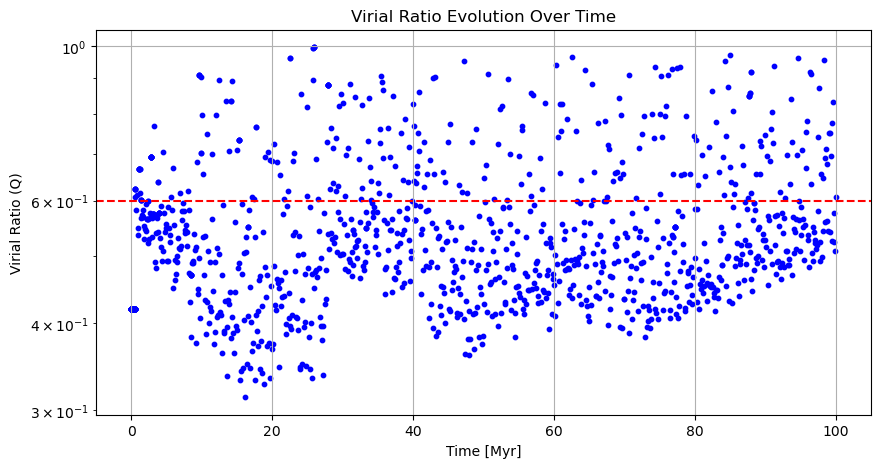

In [65]:
plt.figure(figsize=(10, 5))
plt.scatter(t_clean, q_clean, color='blue', s=10)
plt.axhline(y=0.6, color='r', linestyle='--', label='Q = 0.6 Threshold')
plt.xlabel("Time [Myr]")
plt.ylabel("Virial Ratio (Q)")
# Set y label to log scale
plt.yscale("log")
plt.grid()
plt.title("Virial Ratio Evolution Over Time")

# Filter rows where Q > 0.6
high_q_rows = df_energy[df_energy["Virial Ratio (Q)"] > 0.6]

if not high_q_rows.empty:
    # Get the first occurrence (lowest time)
    first_occurrence = high_q_rows.iloc[0]
    time_found = first_occurrence["Time [Myr]"]
    q_value = first_occurrence["Virial Ratio (Q)"]
    
    print("-" * 50)
    print(f"First time Q > 0.6: {time_found:.4f} Myr - the cluster becomes unbound!")
    print(f"Q value at that time: {q_value:.4f}")
    print("-" * 50)
else:
    print("-" * 50)
    print("Q never exceeded 0.6 in this simulation.")
    print("-" * 50)


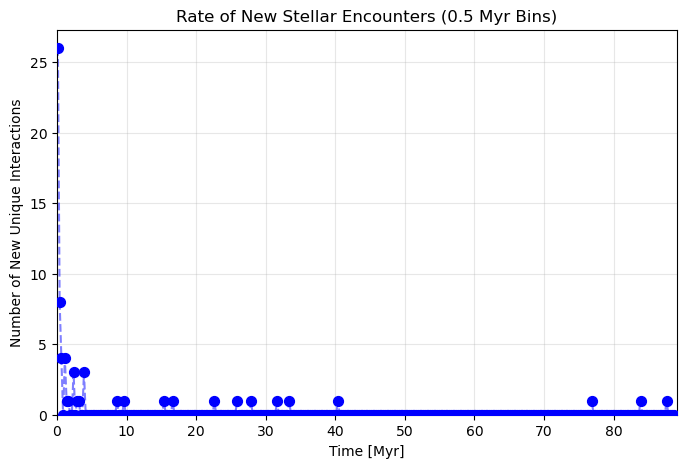

Total unique interactions (pairs) below 1 Myr: 38
Total unique interactions (pairs) below 10 Myr: 54
Total unique interactions (pairs) below 100 Myr: 65


In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Ensure time is in Myr (assuming input is in Years based on column name)
# If your column "time (yr)" is actually years, divide by 1e6.
data["time_Myr"] = data["time (yr)"] / 1e6 

# 2. Identify Unique Pairs
# We create a consistent "Pair ID" regardless of order (A-B is same as B-A)
# We sort the IDs so (1, 2) and (2, 1) both become tuple (1, 2)
data["pair_id"] = data.apply(lambda row: tuple(sorted([row["particle1_id"], row["particle2_id"]])), axis=1)

# 3. Filter for "New" Interactions (First time this pair met)
# We sort by time first to ensure we keep the earliest encounter
first_encounters = data.sort_values("time_Myr").drop_duplicates(subset=["pair_id"], keep="first")

# 4. Define Bins (0.5 Myr intervals)
# Calculate max time to know how many bins we need
max_time = data["time_Myr"].max()
# Create bins: 0, 0.5, 1.0, 1.5 ...
bins = np.arange(0, max_time + 0.5, 0.25) 

# 5. Bin the data
# pd.cut assigns each row to a bin interval
first_encounters["time_bin"] = pd.cut(first_encounters["time_Myr"], bins=bins)

# 6. Count interactions per bin
counts = first_encounters["time_bin"].value_counts().sort_index()

# 7. Prepare Plot Data
# X-axis: Midpoint of each bin (0.25, 0.75, 1.25...)
bin_midpoints = bins[:-1] + 0.25/2
# Y-axis: The counts
y_values = counts.values

# 8. Plot
plt.figure(figsize=(8, 5))
plt.scatter(bin_midpoints, y_values, color='blue', s=50, zorder=5)
plt.plot(bin_midpoints, y_values, color='blue', linestyle='--', alpha=0.5) # Connect dots for clarity

plt.xlabel("Time [Myr]")
plt.ylabel("Number of New Unique Interactions")
plt.title("Rate of New Stellar Encounters (0.5 Myr Bins)")
plt.grid(True, alpha=0.3)
plt.xlim(0, max(bin_midpoints) + 0.5)
plt.ylim(bottom=0)

plt.show()

# # Optional: Print the table
# print("Time (Myr) | New Interactions")
# for t, count in zip(bin_midpoints, y_values):
#     print(f"{t:9.2f} | {count}")

sum_1_myr = 0
sum_10_myr = 0
sum_100_myr = 0

for t, count in zip(bin_midpoints, y_values):
    if t <= 1.0:
        sum_1_myr += count
    if t <= 10.0:
        sum_10_myr += count
    if t <= 100.0:
        sum_100_myr += count

print(f"Total unique interactions (pairs) below 1 Myr: {sum_1_myr}")
print(f"Total unique interactions (pairs) below 10 Myr: {sum_10_myr}")
print(f"Total unique interactions (pairs) below 100 Myr: {sum_100_myr}")


74


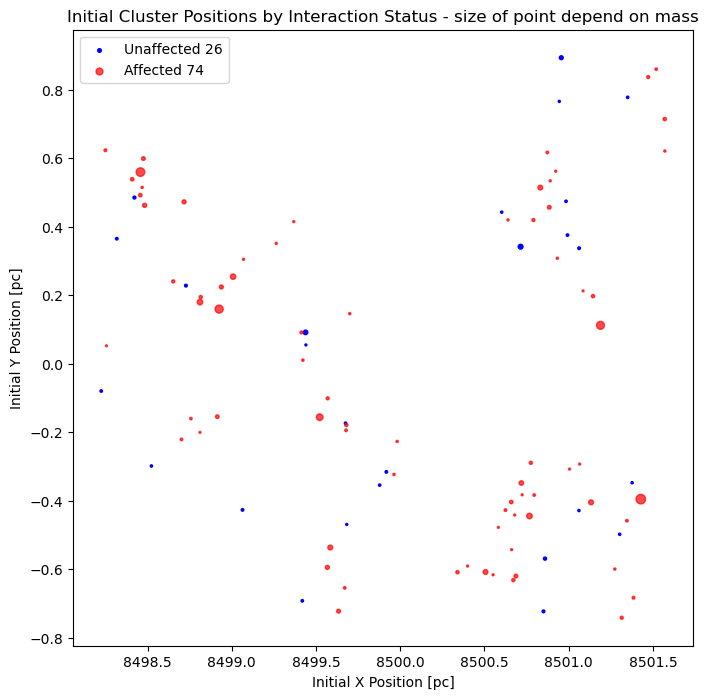

3.11957320056 4.6340452263
3.92091892043 7.22642353629



In [29]:
union_particles = set(data['particle1_id']).union(set(data['particle2_id']))
print(len(union_particles))

unaffected_x, unaffected_y = [], []
affected_x, affected_y = [], []
unaffected_mass, affected_mass = [], []
unaffected_velocity, affected_velocity = [], []
unaffected_vx, affected_vx = [], []
unaffected_vy, affected_vy = [], []
unaffected_vz, affected_vz = [], []
unaffected_distance_to_center, affected_distance_to_center = [], []


for star in initial_state_list:
    if star['key'] in union_particles:
        affected_x.append(star['x0'])
        affected_y.append(star['y0'])
        affected_mass.append(star['mass'] * 2)
        
        affected_vx.append(star['vx0'])
        affected_vy.append(star['vy0'])
        affected_vz.append(star['vz0'])

        velocity = (star['vx0']**2 + star['vy0']**2 + star['vz0']**2)**0.5
        affected_velocity.append(velocity)


    else:
        unaffected_x.append(star['x0'])
        unaffected_y.append(star['y0'])
        unaffected_mass.append(star['mass'] * 2)
        
        unaffected_vx.append(star['vx0'])
        unaffected_vy.append(star['vy0'])
        unaffected_vz.append(star['vz0'])
        velocity = (star['vx0']**2 + star['vy0']**2 + star['vz0']**2)**0.5
        unaffected_velocity.append(velocity)


plt.figure(figsize=(8, 8))
plt.scatter(unaffected_x, unaffected_y, c='blue', s=unaffected_mass, label=f'Unaffected {len(unaffected_x)}')
plt.scatter(affected_x, affected_y, c='red', s=affected_mass, alpha=0.7, label=f'Affected {len(affected_x)}')
plt.xlabel("Initial X Position [pc]")
plt.ylabel("Initial Y Position [pc]")
plt.title("Initial Cluster Positions by Interaction Status - size of point depend on mass")
plt.legend()
plt.show()

print(np.median(unaffected_mass), np.median(affected_mass))
print(np.mean(unaffected_mass), np.mean(affected_mass))

print()



Cluster Bulk Velocity: [36.4166167705, -17.0998203823, -0.000501200362542] kms
Interacting particles: 74


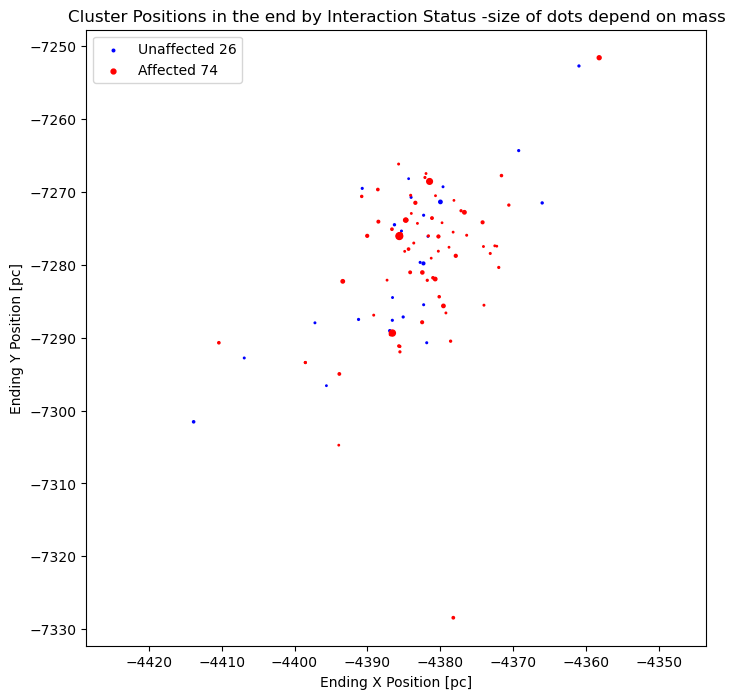

velocities - median, mean , stddev
(7.4834147149384593, 8.6495899358678123)
(7.9699467052475068, 9.5755192776321181)
(4.7404264376146017, 5.9840857477449516)
masses - median, mean , stddev
(1.5597866002780405, 2.3170226131493479)
(1.9604594602163297, 3.6132117681431493)
(1.1924746232879264, 4.1951655256126106)
vx components - median, mean , stddev
(36.280903430278656, 36.449620546136558)
(36.275322061315194, 36.417386336633143)
(0.31272649704098671, 0.50743657920281615)
vy components - median, mean , stddev
(-17.234450961090197, -17.197189986795657)
(-17.118426613704212, -17.181966425076457)
(0.80775234140496577, 0.79150981251887109)
vz components - median, mean , stddev
(0.12960321251697199, 0.034748022861341973)
(0.17175306952821978, 0.03315803467139599)
(0.24428120225464497, 0.61898089051894567)


In [30]:
# 1. Calculate the Velocity of the Center of Mass (V_cm)
v_cm = cluster.center_of_mass_velocity()
print(f"Cluster Bulk Velocity: {v_cm.in_(units.kms)}")

union_particles = set(data['particle1_id']).union(set(data['particle2_id']))
print(f"Interacting particles: {len(union_particles)}")

unaffected_x_end, unaffected_y_end = [], []
affected_x_end, affected_y_end = [], []
unaffected_mass_end, affected_mass_end = [], []
affected_velocity_end, unaffected_velocity_end = [], []
affected_vx_end, unaffected_vx_end = [], []
affected_vy_end, unaffected_vy_end = [], []
affected_vz_end, unaffected_vz_end = [], []

# 2. Iterate
for i in range(len(cluster)):
    
    # Calculate relative velocity components (Star Velocity - Cluster Bulk Velocity)
    dvx = cluster.vx[i] - v_cm[0]
    dvy = cluster.vy[i] - v_cm[1]
    dvz = cluster.vz[i] - v_cm[2]
    
    # Calculate magnitude of this relative velocity vector
    velocity_mag = (dvx**2 + dvy**2 + dvz**2)**0.5
    
    # Visualization scaling: Multiply by 10 or 20 to make the dots visible
    # otherwise a star with 0.5 km/s is invisible (0.5 pixel size)
    velocity_mag = velocity_mag.value_in(units.kms) * 10
    

    if cluster.key[i] in union_particles:
        affected_x_end.append(cluster.x[i].value_in(units.pc))
        affected_y_end.append(cluster.y[i].value_in(units.pc))
        affected_mass_end.append(cluster.mass[i].value_in(units.MSun))
        affected_velocity_end.append(velocity_mag)
        affected_vx_end.append(cluster.vx[i].value_in(units.kms))
        affected_vy_end.append(cluster.vy[i].value_in(units.kms))
        affected_vz_end.append(cluster.vz[i].value_in(units.kms))
    else:
        unaffected_x_end.append(cluster.x[i].value_in(units.pc))
        unaffected_y_end.append(cluster.y[i].value_in(units.pc))
        unaffected_mass_end.append(cluster.mass[i].value_in(units.MSun))
        unaffected_velocity_end.append(velocity_mag)
        unaffected_vx_end.append(cluster.vx[i].value_in(units.kms))
        unaffected_vy_end.append(cluster.vy[i].value_in(units.kms))
        unaffected_vz_end.append(cluster.vz[i].value_in(units.kms))

plt.figure(figsize=(8, 8))

# Added alpha to blue dots so we can see overlaps better
plt.scatter(unaffected_x_end, unaffected_y_end, c='blue', s=unaffected_mass_end, label=f'Unaffected {len(unaffected_x_end)}')
plt.scatter(affected_x_end, affected_y_end, c='red', s=affected_mass_end, label=f'Affected {len(affected_x_end)}')

plt.xlabel("Ending X Position [pc]")
plt.ylabel("Ending Y Position [pc]")
plt.title("Cluster Positions in the end by Interaction Status -size of dots depend on mass")
plt.legend()
plt.axis('equal') # Important for spatial plots
plt.show()

print("velocities - median, mean , stddev")
print((np.median(unaffected_velocity_end), np.median(affected_velocity_end)))
print((np.mean(unaffected_velocity_end), np.mean(affected_velocity_end)))
print((np.std(unaffected_velocity_end), np.std(affected_velocity_end)))

print("masses - median, mean , stddev")
print((np.median(unaffected_mass_end), np.median(affected_mass_end)))
print((np.mean(unaffected_mass_end), np.mean(affected_mass_end)))
print((np.std(unaffected_mass_end), np.std(affected_mass_end)))

print("vx components - median, mean , stddev")
print((np.median(unaffected_vx_end), np.median(affected_vx_end)))
print((np.mean(unaffected_vx_end), np.mean(affected_vx_end)))
print((np.std(unaffected_vx_end), np.std(affected_vx_end)))

print("vy components - median, mean , stddev")
print((np.median(unaffected_vy_end), np.median(affected_vy_end)))
print((np.mean(unaffected_vy_end), np.mean(affected_vy_end)))
print((np.std(unaffected_vy_end), np.std(affected_vy_end)))

print("vz components - median, mean , stddev")
print((np.median(unaffected_vz_end), np.median(affected_vz_end)))
print((np.mean(unaffected_vz_end), np.mean(affected_vz_end)))
print((np.std(unaffected_vz_end), np.std(affected_vz_end)))


In [25]:
union_particles = set(data['particle1_id']).union(set(data['particle2_id']))
print(len(union_particles))

unaffected_x, unaffected_y = [], []
affected_x, affected_y = [], []
unaffected_mass, affected_mass = [], []
unaffected_velocity, affected_velocity = [], []
unaffected_vx, affected_vx = [], []
unaffected_vy, affected_vy = [], []
unaffected_vz, affected_vz = [], []
unaffected_distance_to_center, affected_distance_to_center = [], []
unaffected_distance_to_other_star, affected_distance_to_other_star = [], []

for star in initial_state_list:
    if star['key'] in union_particles:
        affected_x.append(star['x0'])
        affected_y.append(star['y0'])
        affected_mass.append(star['mass'] * 2)
        
        vy = star['vy0'] - 40  # Subtracting bulk motion for analysis
        affected_vx.append(star['vx0'])
        affected_vy.append(vy)
        affected_vz.append(star['vz0'])

        velocity = (star['vx0']**2 + vy**2 + star['vz0']**2)**0.5
        affected_velocity.append(velocity)

        dis_center = ((star['x0']- 8500)**2 + star['y0']**2 + star['z0']**2)**0.5
        affected_distance_to_center.append(dis_center)

        affected_distance_to_other_star.append(star['minimal_distance_to_other_star'])

    else:
        unaffected_x.append(star['x0'])
        unaffected_y.append(star['y0'])
        unaffected_mass.append(star['mass'] * 2)
        
        vy = star['vy0'] - 40  # Subtracting bulk motion for analysis
        unaffected_vx.append(star['vx0'])
        unaffected_vy.append(vy)
        unaffected_vz.append(star['vz0'])
        velocity = (star['vx0']**2 + vy**2 + star['vz0']**2)**0.5
        unaffected_velocity.append(velocity)
        dis_center = ((star['x0']- 8500)**2 + star['y0']**2 + star['z0']**2)**0.5
        unaffected_distance_to_center.append(dis_center)
        unaffected_distance_to_other_star.append(star['minimal_distance_to_other_star'])


#What can be a predictior of being affected? Initial position, mass, velocity?
print("affected_velocity", np.median(affected_velocity), np.mean(affected_velocity), np.std(affected_velocity))
print("unaffected_velocity", np.median(unaffected_velocity), np.mean(unaffected_velocity), np.std(unaffected_velocity))

print("affected_distance_to_center", np.median(affected_distance_to_center), np.mean(affected_distance_to_center), np.std(affected_distance_to_center))
print("unaffected_distance_to_center", np.median(unaffected_distance_to_center), np.mean(unaffected_distance_to_center), np.std(unaffected_distance_to_center))


print("affected_mass", np.median(affected_mass), np.mean(affected_mass), np.std(affected_mass))
print("unaffected_mass", np.median(unaffected_mass), np.mean(unaffected_mass), np.std(unaffected_mass))

print("affected_distance_to_other_star", np.median(affected_distance_to_other_star), np.mean(affected_distance_to_other_star), np.std(affected_distance_to_other_star))
print("unaffected_distance_to_other_star", np.median(unaffected_distance_to_other_star), np.mean(unaffected_distance_to_other_star), np.std(unaffected_distance_to_other_star))

74
affected_velocity 0.731564337265 0.759746550666 0.322928403929
unaffected_velocity 0.747923477454 0.798687232525 0.290550311117
affected_distance_to_center 1.13053842244 1.20992676507 0.36645574023
unaffected_distance_to_center 1.2615080916 1.25837527166 0.39498964378
affected_mass 4.6340452263 7.22642353629 8.39033105123
unaffected_mass 3.11957320056 3.92091892043 2.38494924658
affected_distance_to_other_star 0.0926146418318 0.111011125464 0.0512648286279
unaffected_distance_to_other_star 0.129805186159 0.176366104395 0.123705334097
